In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nb
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
import re

In [3]:
df_kim = pd.read_csv("/home/julia/workspace/rodent_gradients/interneurons.csv", header=1)

In [4]:
mcc = MouseConnectivityCache(manifest_file=
                             '/home/julia/data/gradients/atlas/allen_api/mouse_connectivity_manifest.json')
structure_tree = mcc.get_structure_tree()
iso_structs = structure_tree.descendants([315])[0]

### Make a dataframe with only the layer 4 to 6 structures

In [6]:
l4_6 = []
for i in range(len(iso_structs)):
#    if 'layer 4' in iso_structs[i]['name'].lower():
#        l4_6.append(iso_structs[i])
    if 'layer 5' in iso_structs[i]['name'].lower():
        l4_6.append(iso_structs[i])
    elif 'layer 6a' in iso_structs[i]['name'].lower():
        l4_6.append(iso_structs[i])
    elif 'layer 6b' in iso_structs[i]['name'].lower():
        l4_6.append(iso_structs[i])
df4_6 = pd.DataFrame()
for r in l4_6:
    df4_6 = df4_6.append(df_kim.loc[df_kim['ROI'] == r['acronym']], ignore_index=True)
    
df4_6['id']=np.nan
for r in l4_6:
    df4_6.loc[df4_6['ROI']==r['acronym'],'id'] = r['id']

In [7]:
df4_6['g0'] = np.nan
df4_6['g1'] = np.nan
df4_6['g2'] = np.nan
df4_6['g3'] = np.nan
df4_6['g4'] = np.nan
df4_6['g5'] = np.nan

In [8]:
img = nb.load("/home/julia/data/gradients/atlas/allen_api/annotation/annotation_200um.nii.gz")
annot = img.get_data()
gradients = nb.load('/home/julia/data/gradients/results/embedding_vol/embed.nii.gz').get_data()

In [9]:
for idx in df4_6['id']:
    for g in range(6):
        df4_6.loc[df4_6['id']==idx, 'g%s' %str(g)] = np.nanmean(gradients[:,:,:,g][annot==idx])

/home/julia/workspace/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
df4_6 = df4_6.dropna(axis=0)
df4_6 = df4_6.drop(columns=['Full name', 'structureOrder', 'standard deviation', 'standard deviation.1',
                           'standard deviation.2', 'standard deviation.3', 'standard deviation.4', 
                            'standard deviation.5', 'standard deviation.6', 'Average.3', 'Average.4',
                           'Average.5', 'Average.6'])

In [11]:
df4_6 = df4_6.rename(columns={"Average": "PV avg", "Average.1": "SST avg",  "Average.2": "VIP avg"})

In [12]:
for a in df4_6["ROI"]:
    df4_6.loc[df4_6["ROI"]==a, "PV avg"] = int(df4_6[df4_6["ROI"]==a]['PV avg'].values[0].replace(u'\xa0', u''))
    df4_6.loc[df4_6["ROI"]==a, "SST avg"] = int(df4_6[df4_6["ROI"]==a]['SST avg'].values[0].replace(u'\xa0', u''))
    df4_6.loc[df4_6["ROI"]==a, "VIP avg"] = int(df4_6[df4_6["ROI"]==a]['VIP avg'].values[0].replace(u'\xa0', u''))

In [27]:
df4_6["PV/SST"] = df4_6['PV avg'] / (df4_6['PV avg']+df4_6['SST avg'])

In [44]:
df4_6.to_csv("/home/julia/data/gradients/atlas/interneurons/infragranular_regions.csv")

In [50]:
for g in range(6):
    for c in ['PV avg', 'SST avg', 'VIP avg', 'PV/SST']:
        r = stats.spearmanr(df4_6['g%i' %g], df4_6[c])
        if r[1]*73*24<0.05:
            print('Gradient %i, %s:' %(g,c), r)

Gradient 2, PV avg: SpearmanrResult(correlation=0.49254122770928715, pvalue=9.5829172661938265e-06)
Gradient 4, PV/SST: SpearmanrResult(correlation=-0.58425891645069727, pvalue=5.7464231259109088e-08)


### Plotting

In [31]:
df_plotting = pd.read_csv('/home/julia/workspace/rodent_gradients/finest_regions.csv')

In [32]:
df4_6['cluster'] = np.nan

In [33]:
for a in df4_6["ROI"]:
    df4_6.loc[df4_6['ROI']==a, 'cluster'] = df_plotting.loc[df_plotting['acronym']==re.split(r'(\d+)', a)[0], 
                                                            'cluster'].values[0]

In [34]:
df4_6.loc[df4_6['ROI']=='MOp5', 'cluster'] = 'motor'
df4_6.loc[df4_6['ROI']=='MOs5', 'cluster'] = 'motor'
df4_6.loc[df4_6['ROI']=='MOp6a', 'cluster'] = 'motor'
df4_6.loc[df4_6['ROI']=='MOs6a', 'cluster'] = 'motor'
df4_6.loc[df4_6['cluster']=='somatomotor', 'cluster'] = 'somatosensory'

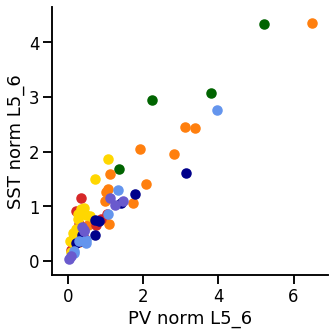

In [36]:
clusters = ['motor', 'somatosensory', 'prefrontal','lateral', 'medial', 'visual', 'auditory']
colors = ['darkgreen', 'tab:orange', 'tab:red', 'gold', 'darkblue','cornflowerblue','slateblue']
sns.set_context('talk')
fig = plt.figure(figsize=(5,5))

pv_norm = np.mean(df4_6['PV avg'])
sst_norm = np.mean(df4_6['SST avg'])

for c in range(len(clusters)):
    regions = list(df4_6.loc[df4_6['cluster']==clusters[c], "ROI"])
    for r in regions:
        plt.scatter(df4_6.loc[df4_6['ROI']==r, 'PV avg'].values[0] / pv_norm, 
                    df4_6.loc[df4_6['ROI']==r, 'SST avg'].values[0] / sst_norm, 
                    color=colors[c], label=clusters[c])
plt.xlabel('PV norm L5_6')
plt.ylabel('SST norm L5_6')
plt.tight_layout()
sns.despine()

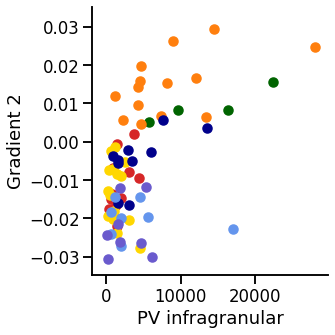

In [51]:
clusters = ['motor', 'somatosensory', 'prefrontal','lateral', 'medial', 'visual', 'auditory']
colors = ['darkgreen', 'tab:orange', 'tab:red', 'gold', 'darkblue','cornflowerblue','slateblue']
sns.set_context('talk')
fig = plt.figure(figsize=(5,5))

pv_norm = np.mean(df4_6['PV avg'])
sst_norm = np.mean(df4_6['SST avg'])

for c in range(len(clusters)):
    regions = list(df4_6.loc[df4_6['cluster']==clusters[c], "ROI"])
    for r in regions:
        plt.scatter(df4_6.loc[df4_6['ROI']==r, 'PV avg'].values[0], 
                    df4_6.loc[df4_6['ROI']==r, 'g2'].values[0], 
                    color=colors[c], label=clusters[c])
plt.xlabel('PV infragranular')
plt.ylabel('Gradient 2')
plt.tight_layout()
sns.despine()

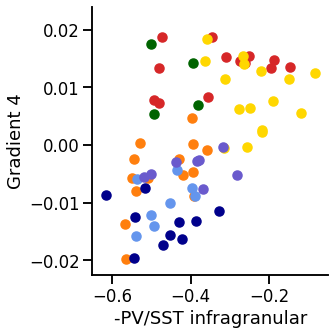

In [53]:
clusters = ['motor', 'somatosensory', 'prefrontal','lateral', 'medial', 'visual', 'auditory']
colors = ['darkgreen', 'tab:orange', 'tab:red', 'gold', 'darkblue','cornflowerblue','slateblue']
sns.set_context('talk')
fig = plt.figure(figsize=(5,5))

pv_norm = np.mean(df4_6['PV avg'])
sst_norm = np.mean(df4_6['SST avg'])

for c in range(len(clusters)):
    regions = list(df4_6.loc[df4_6['cluster']==clusters[c], "ROI"])
    for r in regions:
        plt.scatter(-df4_6.loc[df4_6['ROI']==r, 'PV/SST'].values[0], 
                    df4_6.loc[df4_6['ROI']==r, 'g4'].values[0], 
                    color=colors[c], label=clusters[c])
plt.xlabel('-PV/SST infragranular')
plt.ylabel('Gradient 4')
plt.tight_layout()
sns.despine()